# Split dataset into train / test folders (per-class)
This cell adds a utility to split an existing directory of class subfolders into `train` and `test` folders while preserving class subfolders.

Usage notes:
- Point `src` to the folder that contains one subfolder per class (e.g. `data/` in this repo).
- `dst` will receive `train/<class>` and `test/<class>` folders (e.g. `DATASET/`).
- The function can either copy (default) or move files. Use a seed for reproducible splits.

# 1. DataSet

In [2]:
from pathlib import Path

data = Path("data/")
train_dir = data / "train"
test_dir = data / "test"

In [3]:
train_dir,test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

# 2. Transformation

In [4]:
from torchvision import transforms
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# train_transforms = transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.TrivialAugmentWide(num_magnitude_bins=31),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485,0.456,0.406],
#                          std = [0.229,0.224,0.225])
# ]) 

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   # random zoom/crop
    transforms.RandomHorizontalFlip(p=0.5),     
    transforms.RandomRotation(15),           
    transforms.TrivialAugmentWide(num_magnitude_bins=31),   # strong random aug
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


actual_transforms = weights.transforms()

# 3. Load the Image Data

In [5]:
from PIL import Image
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=actual_transforms)

# 4. DataLoader

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=2)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False,
                             num_workers=2)

# 5 Setting up Device Agnoistic Code

In [7]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
device

'cuda'

# 6. Using a PreTrained Model (Transfer Learning)

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# 7. Seeing the Summary of the Model

In [10]:
from torchinfo import summary

summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# 8. Feature Extracting and Fine Tunning for experiment

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
classes = train_data.classes
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [13]:
# # Example: fine-tune EfficientNet-B0 last layers
# for name, param in model.named_parameters():
#     if "features.6" in name or "features.7" in name:  # last two feature blocks
#         param.requires_grad = True
#     else:
#         param.requires_grad = False


# 9. Changing the Classifer Layer

In [14]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(classes)

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)

In [15]:
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 6]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 10 Setup the Optimizer and Loss Function

In [16]:
optimizer = torch.optim.Adam(params=model.parameters(),lr = 0.001)
loss_fn = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# 11. Train the Model

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
from train import train

start_time = timer()

model_results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    # scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=15,
    device=device
)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

d:\AI\ML-GPU-Env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  7%|▋         | 1/15 [00:26<06:16, 26.88s/it]

Epoch: 0 | Train loss: 1.3331 | Train acc:0.5335 | Test loss:0.9889 | Test acc:0.7196


 13%|█▎        | 2/15 [00:49<05:17, 24.46s/it]

Epoch: 1 | Train loss: 0.9684 | Train acc:0.6781 | Test loss:0.7906 | Test acc:0.7645


 20%|██        | 3/15 [01:14<04:54, 24.51s/it]

Epoch: 2 | Train loss: 0.8561 | Train acc:0.7007 | Test loss:0.7082 | Test acc:0.7670


 27%|██▋       | 4/15 [01:41<04:43, 25.79s/it]

Epoch: 3 | Train loss: 0.7844 | Train acc:0.7310 | Test loss:0.6599 | Test acc:0.7743


 33%|███▎      | 5/15 [02:09<04:23, 26.32s/it]

Epoch: 4 | Train loss: 0.7414 | Train acc:0.7461 | Test loss:0.6465 | Test acc:0.7857


 40%|████      | 6/15 [02:31<03:43, 24.78s/it]

Epoch: 5 | Train loss: 0.7067 | Train acc:0.7560 | Test loss:0.6185 | Test acc:0.7840


 47%|████▋     | 7/15 [03:00<03:31, 26.45s/it]

Epoch: 6 | Train loss: 0.6875 | Train acc:0.7536 | Test loss:0.6137 | Test acc:0.7843


 53%|█████▎    | 8/15 [03:28<03:08, 26.88s/it]

Epoch: 7 | Train loss: 0.6688 | Train acc:0.7694 | Test loss:0.5898 | Test acc:0.7793


 60%|██████    | 9/15 [03:54<02:38, 26.40s/it]

Epoch: 8 | Train loss: 0.6654 | Train acc:0.7627 | Test loss:0.5790 | Test acc:0.8013


 67%|██████▋   | 10/15 [04:33<02:31, 30.37s/it]

Epoch: 9 | Train loss: 0.6207 | Train acc:0.7847 | Test loss:0.5517 | Test acc:0.8041


 73%|███████▎  | 11/15 [05:01<01:59, 29.76s/it]

Epoch: 10 | Train loss: 0.6099 | Train acc:0.7897 | Test loss:0.5519 | Test acc:0.8016


 80%|████████  | 12/15 [05:25<01:24, 28.04s/it]

Epoch: 11 | Train loss: 0.6215 | Train acc:0.7721 | Test loss:0.5478 | Test acc:0.8019


 87%|████████▋ | 13/15 [05:50<00:54, 27.01s/it]

Epoch: 12 | Train loss: 0.6418 | Train acc:0.7712 | Test loss:0.5512 | Test acc:0.8147


 93%|█████████▎| 14/15 [06:16<00:26, 26.76s/it]

Epoch: 13 | Train loss: 0.6444 | Train acc:0.7743 | Test loss:0.5553 | Test acc:0.8055


100%|██████████| 15/15 [06:41<00:00, 26.80s/it]

Epoch: 14 | Train loss: 0.6294 | Train acc:0.7767 | Test loss:0.5374 | Test acc:0.7997
[INFO] Total training time: 401.948 seconds


# 12 Loss Curve

In [18]:
import matplotlib.pyplot as plt
from typing import Tuple,Dict,List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plot training curves of a results dictionary."""

    # GEt the loss values off the results dictionary(training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuray values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label="train_loss")
    plt.plot(epochs,test_loss,label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy,label="train_accuracy")
    plt.plot(epochs,test_accuracy,label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    

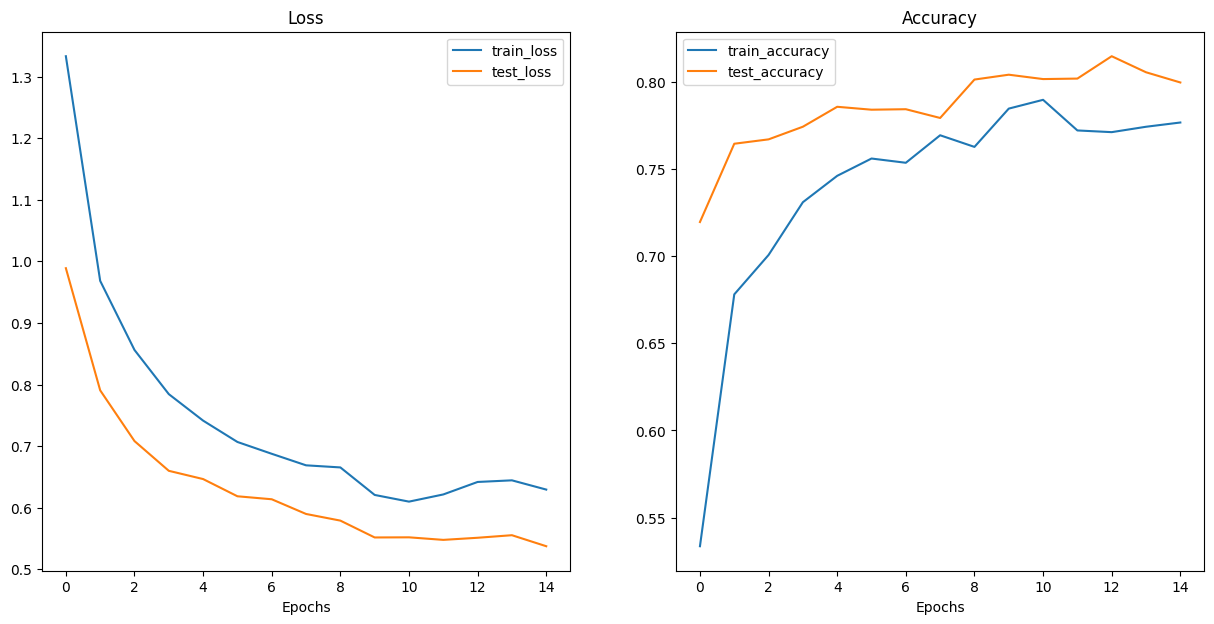

In [19]:
plot_loss_curves(model_results)

# 13 Checking the Model

In [20]:

from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)
    print(target_image_pred)

tensor([[-3.3054,  3.8330, -1.2624, -5.0289,  1.1369, -2.3774]],
       device='cuda:0')


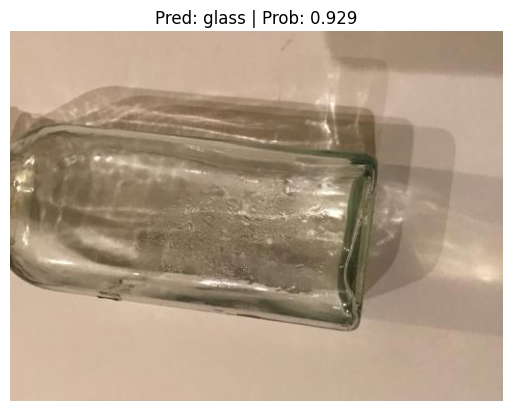

In [21]:
des = Path("glass116.jpg")

pred_and_plot_image(
    model=model,
    image_path=des,
    class_names=classes,
    transform=actual_transforms,
    device=device
)

# 14 Saving The Model

In [22]:
torch.save(obj=model.state_dict(),f="waste_classifier_model.pth")